In [1]:
!pip install -Uqq torch torchaudio librosa

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.19.0+cpu requires torch==2.4.0, but you have torch 2.4.1 which is incompatible.


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchaudio
import os

DATA_PATH = '/kaggle/input/google-speech-commands'
    
sample_file = os.path.join(DATA_PATH, 'bed', '01648c51_nohash_1.wav')
print(sample_file)
waveform, sample_rate = torchaudio.load(sample_file)

print("Waveform Shape:", waveform.shape)
print("Sample Rate:", sample_rate)


/kaggle/input/google-speech-commands/bed/01648c51_nohash_1.wav
Waveform Shape: torch.Size([1, 16000])
Sample Rate: 16000


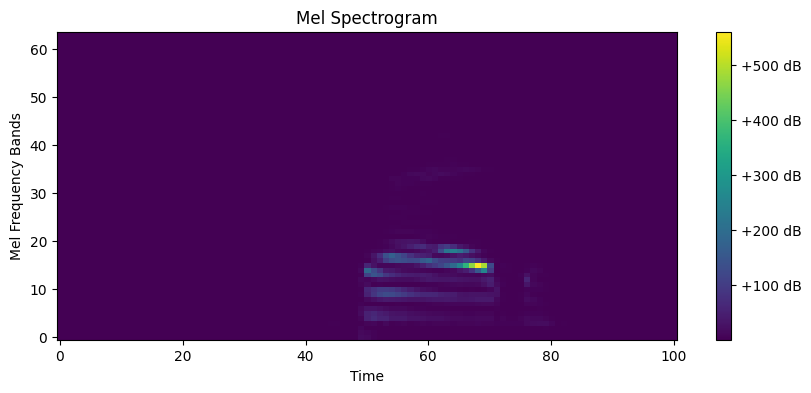

In [3]:
import torchaudio.transforms as T

# Mel Spectrogram transformation for Google Speech Commands dataset
mel_spectrogram_transform = T.MelSpectrogram(
    sample_rate=16000,  
    n_fft=400,          
    hop_length=160,     
    n_mels=64,          
    f_min=0,            
    f_max=8000         
)

# Example usage with an audio file
import torchaudio
import matplotlib.pyplot as plt

audio_path = sample_file  # Replace with the path to your audio file
waveform, sample_rate = torchaudio.load(audio_path)

# Ensure waveform is resampled to 16000 Hz
if sample_rate != 16000:
    resample_transform = T.Resample(orig_freq=sample_rate, new_freq=16000)
    waveform = resample_transform(waveform)

# Apply the Mel Spectrogram transformation
mel_spectrogram = mel_spectrogram_transform(waveform)

# Visualize the Mel Spectrogram
plt.figure(figsize=(10, 4))
plt.imshow(mel_spectrogram[0].detach().numpy(), origin='lower', aspect='auto', cmap='viridis')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram')
plt.xlabel('Time')
plt.ylabel('Mel Frequency Bands')
plt.show()

/opt/conda/lib/python3.10/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


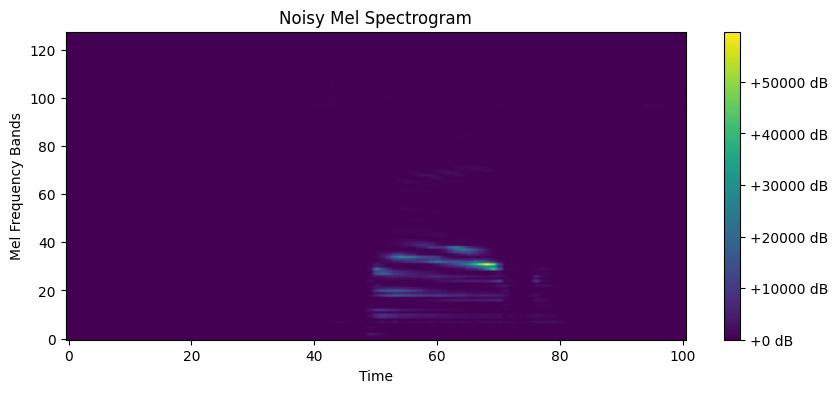

In [4]:
import torchaudio
import torchaudio.transforms as T
import random
import torch
import os

# Parameters
sample_rate = 16000
noise_dir = "/kaggle/input/google-speech-commands/_background_noise_"  

noise_files = [os.path.join(noise_dir, f) for f in os.listdir(noise_dir) if f.endswith('.wav')]
noises = [torchaudio.load(nf)[0] for nf in noise_files]

def add_background_noise(waveform, noises, snr_db=0):
    """
    Adds a random background noise to the waveform at the specified SNR (Signal-to-Noise Ratio).
    Args:
    - waveform (Tensor): The original waveform tensor.
    - noises (list of Tensor): List of loaded noise tensors.
    - snr_db (float): Desired Signal-to-Noise Ratio in dB.
    
    Returns:
    - noisy_waveform (Tensor): Waveform mixed with background noise.
    """
    noise = random.choice(noises)
    
    # If noise is shorter than the waveform, pad it, otherwise, crop it
    if noise.shape[1] < waveform.shape[1]:
        noise = torch.cat([noise, torch.zeros(1, waveform.shape[1] - noise.shape[1])], dim=1)
    else:
        start_idx = random.randint(0, noise.shape[1] - waveform.shape[1])
        noise = noise[:, start_idx:start_idx + waveform.shape[1]]
    
    # Normalize the noise and waveform to have mean 0 and std 1
    waveform = waveform - waveform.mean()
    waveform = waveform / (waveform.std() + 1e-6)
    noise = noise - noise.mean()
    noise = noise / (noise.std() + 1e-6)
    
    # Calculate scaling factor for noise to achieve the desired SNR
    signal_power = waveform.norm(p=2)
    noise_power = noise.norm(p=2)
    noise_scaling_factor = signal_power / (10 ** (snr_db / 20)) / (noise_power + 1e-6)
    noisy_waveform = waveform + noise_scaling_factor * noise
    
    return noisy_waveform

# Example usage: Adding noise to an audio file
audio_path = sample_file
waveform, sr = torchaudio.load(audio_path)

# Ensure the waveform is resampled to the desired sample rate
if sr != sample_rate:
    resample_transform = T.Resample(orig_freq=sr, new_freq=sample_rate)
    waveform = resample_transform(waveform)

# Apply background noise augmentation
noisy_waveform = add_background_noise(waveform, noises, snr_db=10)

# Save or visualize the augmented waveform as needed
# torchaudio.save("path_to_save_noisy_audio.wav", noisy_waveform, sample_rate)

# Display the Mel spectrogram of the noisy audio for visualization
mel_spectrogram_transform = T.MelSpectrogram(sample_rate=sample_rate, n_fft=400, hop_length=160, n_mels=128)
mel_spectrogram = mel_spectrogram_transform(noisy_waveform)

plt.figure(figsize=(10, 4))
plt.imshow(mel_spectrogram[0].detach().numpy(), origin='lower', aspect='auto', cmap='viridis')
plt.colorbar(format='%+2.0f dB')
plt.title('Noisy Mel Spectrogram')
plt.xlabel('Time')
plt.ylabel('Mel Frequency Bands')
plt.show()

